In [1]:
import findspark
findspark.init('/usr/local/spark')

ModuleNotFoundError: No module named 'findspark'

In [2]:
from pyspark import SparkContext, SparkConf, SQLContext
from operator import add

import pandas as pd
import re
import numpy as np
import hashlib
import csv

from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinHashLSH
from pyspark.mllib.linalg import Vectors

In [3]:
# sc = SparkContext.getOrCreate()
conf = SparkConf()
master = "local[*]"
conf.set("spark.app.name", "bigwj")
conf.set("spark.master", master)
conf.set("spark.executor.cores", 10)
conf.set("spark.executor.instances", 1)
conf.set("spark.executor.memory", "40g")
conf.set('spark.driver.memory', '45G')
conf.set('spark.driver.maxResultSize', '10G')
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
sc = SparkContext(conf=conf) 
questionFile=sc.textFile("../../Questions.csv")
answerFile=sc.textFile("../../Answers.csv")
# questionFile=sc.textFile("test_q.csv")
# answerFile=sc.textFile("test_a.csv")
# tagFile = sc.textFile("test_t.csv")
tagFile = sc.textFile("../../Tags.csv")
stopWordsFile = sc.textFile("stopwords.txt")
print("finished")

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=PySparkShell, master=local[*]) created by <module> at /Users/Sisyphus/anaconda3/lib/python3.6/site-packages/IPython/utils/py3compat.py:186 

In [3]:
#Read sample of question.csv(5%), generate the keywords list to focus on

In [4]:
questionWithHeader = questionFile.map(lambda line: line.split(",")).filter(lambda line: len(line)>1)
header = questionWithHeader.first() #extract header
question = questionWithHeader.filter(lambda x: x != header)
print(question.count())

1264216


In [5]:
questionSample=question.sample(False,0.05,81)
questionLower = questionSample.map(lambda x: (x[0], re.sub("<.*?>", " ", (x[5]+x[6]).lower())))
def f(x): return re.sub('[^a-zA-Z0-9\']+', ' ', x)
questionLower = questionLower.mapValues(f)
def f2(x): return x.split(" ")
questionPairRaw = questionLower.flatMapValues(f2)
print(questionPairRaw.count())

12511645


In [6]:
stopWordsList = stopWordsFile.collect()
questionPair=questionPairRaw.filter(lambda x: x[1] not in stopWordsList)
questionPairfilter=questionPair.filter(lambda x:x[1]!="")
questionPairStage1 = questionPairfilter.map(lambda x:(x[0]+"@"+x[1],1)).reduceByKey(add)
N = len(questionPair.countByKey())
print(N)

63340


In [7]:
questionPairStage2MapPhase = questionPairStage1.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
stage2Map = questionPairStage2MapPhase.countByKey()
questionPairStage2 = questionPairStage2MapPhase.map(lambda x:(x[0]+"@"+x[1].split("=")[0],(1+np.log(int(x[1].split("=")[1])))*np.log(N/stage2Map.get(x[0]))))
questionPairStage3MapPhase = questionPairStage2.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
def f3_1(a,b): return float(a)+float(b.split("=")[1])*float(b.split("=")[1])
def f3_2(a,b): return float(a)+float(b)
questionPairStage3AggByKey = questionPairStage3MapPhase.aggregateByKey(0.0,f3_1,f3_2)
print(questionPairStage3AggByKey.count())

63340


In [8]:
questionPairStage3AggByKeysqr = questionPairStage3AggByKey.map(lambda x:(x[0],np.sqrt(x[1])))
stage3Map = questionPairStage3AggByKeysqr.collectAsMap()
questionPairStage3 = questionPairStage3MapPhase.map(lambda x:(x[0],x[1].split("=")[0]+"="+str(float(x[1].split("=")[1])/stage3Map.get(x[0]))))
num_keywords = 7
def f4_1(a,b):
    c=[]
    for i in range(num_keywords):
        if float(b.split("=")[1])>float(a[i].split("=")[1]):
            a[i]=b
            break
    return a
def f4_2(a,b):
    for i in range(num_keywords): #b
        for j in range(num_keywords): #a
            if float(b[i].split("=")[1])>float(a[j].split("=")[1]):
                a[j] = b[i]
                break
    return a
questionPairStage4 = questionPairStage3.aggregateByKey(["a=0","b=0","c=0","d=0","e=0","f=0","g=0"],f4_1,f4_2)
print(questionPairStage4.count())
questionPairStage4.take(5)

63340


[('432500',
  ['2005=0.4025217297951289',
   'helptext=0.27349687887229185',
   'feature=0.2666456216421531',
   'sql=0.2468161077629039',
   'procedures=0.18900209536441626',
   'enterprise=0.18009071452331646',
   'studio=0.11578629361809115']),
 ('435980',
  ['recompile=0.3558572862285933',
   "recompile'=0.3243447697293484",
   'justifiable=0.3243447697293484',
   "'with=0.2633426554112979",
   'health=0.20678638100994748',
   'commented=0.1720051433839007',
   'find=0.10636857817414502']),
 ('525430',
  ['gameconfig=0.3846834629964711',
   'getscreensize=0.20915349295126862',
   'getextendedstate=0.1474200482653507',
   'graphicsconfiguration=0.1474200482653507',
   'screenmaximized=0.1474200482653507',
   '3200x1200=0.1474200482653507',
   'windowy=0.13817789251386475']),
 ('767570',
  ['apikey=0.27488256162241737',
   "'getbyshortname'=0.26984307391898",
   'emp=0.2021670645524186',
   'getemployeebyshortname=0.12858167055251382',
   "'getbyid'=0.12858167055251382",
   "'emprest

In [ ]:
#Get the keywords set for threshold 0.4, the threshold can be adjusted.

In [9]:
def fmap1(x):
    output=""
    for i in range(num_keywords):
        y=x[1][i].split("=")
        if float(y[1])>0.4:
           output+=y[0]+";"
    return ("key",output)
keywordlist=questionPairStage4.map(fmap1).reduceByKey(add)
keywords=keywordlist.take(1)
words=keywords[0][1][:-1]
keywordset=set(words.split(";"))
print(len(keywordset))
print(keywordset)

26022
{'namespaces', 'quotedstr', "'1a'", 'su', 'compute', 'strudcutres', 'membership', 'jasperreports', 'mbuttondown', 'checkpointtimeout', 'arnold', 'curveeasein', 'parametertree', 'hashset', "jsgz'", '5005', 'customerform', 'ljava', 'pdfclown', 'weekarchiveview', 'anonymousmode', 'samlrequest', 'tikiwiki', 'relx', 'fixdep', 'classroom', 'rf', 'performances', 'testnamespace', '2x', 'prod', 'activating', 'omega', 'rotated', 'walking', 'prrcdj', 'untick', 'warehouse', 'ironscheme', 'arcs', 'formpanel', 'slipped', 'slices', 'onesignal', 'minimizing', 'stylings', 'jpeg', 'fragments', 'keyed', 'psexec', 'autonumbering', 'cents', 'ar', 'arff', 'meter', 'plz', '90e7', 'nosensor', 'iter', 'manifold', 'pdfstream', 'nsxmlparser', 'plunk', 'showimg', 'emailindex', 'relatedentities', 'specifier', 'idle', 'datatopost', "external'", "eth0's", 'tclerror', 'appregistry', 'mrmage', 'finalresult', 'p2s', 'stash', 'payments', 'odata', 'communicate', '1file', 'composizione', 'overallenergy', 'tk1', 'zam

In [10]:
#turn oringinal question pairs to pairs only keep the keywords,get 7 keywords for each question

In [11]:
questionLower = question.map(lambda x: (x[0], re.sub("<.*?>", " ", (x[5]+x[6]).lower())))
def f(x): return re.sub('[^a-zA-Z0-9\']+', ' ', x)
questionLower = questionLower.mapValues(f)
def f2(x): return x.split(" ")
questionPairRaw = questionLower.flatMapValues(f2)
questionPair=questionPairRaw.filter(lambda x: x[1] in keywordset)
print(questionPair.count())

63607776


In [12]:
questionPairfilter=questionPair.filter(lambda x:x[1]!="")
questionPairStage1 = questionPairfilter.map(lambda x:(x[0]+"@"+x[1],1)).reduceByKey(add)
N = len(questionPair.countByKey())
questionPairStage2MapPhase = questionPairStage1.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
stage2Map = questionPairStage2MapPhase.countByKey()
questionPairStage2 = questionPairStage2MapPhase.map(lambda x:(x[0]+"@"+x[1].split("=")[0],(1+np.log(int(x[1].split("=")[1])))*np.log(N/stage2Map.get(x[0]))))
print(questionPairStage2.count())
print(questionPairStage2.take(5))

26826499
[('statement@80', 6.213796737970658), ('log@650', 2.823660249534865), ('ordering@1610', 6.270827857079348), ('asax@2770', 7.173611890114138), ('ends@2770', 5.225787019213081)]


In [13]:
questionPairStage3MapPhase = questionPairStage2.map(lambda x:(x[0].split("@")[1],x[0].split("@")[0]+"="+str(x[1])))
def f3_1(a,b): return float(a)+float(b.split("=")[1])*float(b.split("=")[1])
def f3_2(a,b): return float(a)+float(b)
questionPairStage3AggByKey = questionPairStage3MapPhase.aggregateByKey(0.0,f3_1,f3_2)
questionPairStage3AggByKeysqr = questionPairStage3AggByKey.map(lambda x:(x[0],np.sqrt(x[1])))
stage3Map = questionPairStage3AggByKeysqr.collectAsMap()
print(stage3Map.get('90'))

18.138628867423357


In [14]:
questionPairStage3 = questionPairStage3MapPhase.map(lambda x:(x[0],x[1].split("=")[0]+"="+str(float(x[1].split("=")[1])/stage3Map.get(x[0]))))

num_keywords = 7
def f4_1(a,b):
    c=[]
    for i in range(num_keywords):
        if float(b.split("=")[1])>float(a[i].split("=")[1]):
            a[i]=b
            break
    return a
def f4_2(a,b):
    for i in range(num_keywords): #b
        for j in range(num_keywords): #a
            if float(b[i].split("=")[1])>float(a[j].split("=")[1]):
                a[j] = b[i]
                break
    return a
questionPairStage4 = questionPairStage3.aggregateByKey(["a=0","b=0","c=0","d=0","e=0","f=0","g=0"],f4_1,f4_2)
print(questionPairStage4.take(5))

[('11045600', ['spy=0.4022372340624075', 'memcached=0.40046396170611315', 'iq=0.2682720811098177', 'cas=0.21710969227786978', '06=0.19237756374021836', 'exp=0.16976527318560644', 'reopening=0.11323861895188624']), ('20190370', ['somepassword=0.24379302792985552', 'email=0.20599149811569897', 'curl=0.1876550581771989', 'json=0.17598986475927464', 'signin=0.17540672479784009', 'params=0.15101619659236887', 'users=0.1317749698512696']), ('709750', ['ap=0.5306554508227387', 'exists=0.21756140153739933', 'node=0.209311584961927', 'meta=0.19524428649725567', 'item=0.13844856429720914', 'f=0', 'g=0']), ('3100530', ['partition=0.4886399665803068', 'sessions=0.3526750473401409', 'classroom=0.3229779125487818', 'columnname=0.26960957160834514', 'sql=0.2610448625144928', 'teacher=0.2518435117954284', 'room=0.22114899722731823']), ('20545020', ['playername=0.4617611785484124', 'selectonemenu=0.4368088707236495', 'clubs=0.18640877943916384', 'saved=0.09869212340147022', 'columns=0.07916009617020073

In [15]:
outMap=questionPairStage4.collectAsMap()
tagWithHeader = tagFile.map(lambda line: line.split(",")).filter(lambda line: len(line)>1)
header = tagWithHeader.first() #extract header
tag = tagWithHeader.filter(lambda x: x != header)
tagLower = tag.map(lambda x: (x[0], x[1].lower()))
def f0(x): return re.sub('[^a-zA-Z]+', '', x)
tagLower = tagLower.mapValues(f0)
tag_1000 = tagLower.map(lambda x: (x[0], x[1]+"=1000"))
questionPairStage5=questionPairStage4.map(lambda x:(x[0],x[1][0]+":"+x[1][1]+":"+x[1][2]+":"+x[1][3]+":"+x[1][4]+":"+x[1][5]+":"+x[1][6]) )
print(questionPairStage5.take(5))

[('11045600', 'spy=0.4022372340624075:memcached=0.40046396170611315:iq=0.2682720811098177:cas=0.21710969227786978:06=0.19237756374021836:exp=0.16976527318560644:reopening=0.11323861895188624'), ('20190370', 'somepassword=0.24379302792985552:email=0.20599149811569897:curl=0.1876550581771989:json=0.17598986475927464:signin=0.17540672479784009:params=0.15101619659236887:users=0.1317749698512696'), ('709750', 'ap=0.5306554508227387:exists=0.21756140153739933:node=0.209311584961927:meta=0.19524428649725567:item=0.13844856429720914:f=0:g=0'), ('3100530', 'partition=0.4886399665803068:sessions=0.3526750473401409:classroom=0.3229779125487818:columnname=0.26960957160834514:sql=0.2610448625144928:teacher=0.2518435117954284:room=0.22114899722731823'), ('20545020', 'playername=0.4617611785484124:selectonemenu=0.4368088707236495:clubs=0.18640877943916384:saved=0.09869212340147022:columns=0.07916009617020073:loop=0.07188966202693278:g=0')]


In [ ]:
#union the keywords of each question 

In [16]:
questionPairStage6=questionPairStage5.union(tag_1000)
def f6_1(a,b):
    return a+":"+b
def f6_2(a,b):
    return a+b
questionPairStage6=questionPairStage6.aggregateByKey("",f6_1,f6_2).map(lambda x: (x[0], x[1][1:]))

In [17]:
print(questionPairStage6.take(10))

[('20545020', 'playername=0.4617611785484124:selectonemenu=0.4368088707236495:clubs=0.18640877943916384:saved=0.09869212340147022:columns=0.07916009617020073:loop=0.07188966202693278:g=0:jsp=1000:jsf=1000:jstl=1000'), ('13330390', "'token'=0.43224567152124294:token=0.3400778269224963:session=0.2161223272824096:uniqid=0.16966832542215102:malicious=0.1641434988946986:hashed=0.15267633603349934:check=0.0592781142952363:php=1000:csrf=1000"), ('9339250', 'sizeof=0.5202420985630823:arr=0.40995543615528335:cout=0.35231109141686034:dt=0.3293982450318132:int=0.24291813645302887:argv=0.17974358452746153:output=0.0954886424870393:c=1000:c=1000:size=1000'), ('5875110', 'metrics=0.5154148578616131:xyz=0.4327645195895996:constant=0.23453353408956562:attribute=0.1775125335078302:model=0.14082842176856294:f=0:g=0:rubyonrails=1000:ruby=1000'), ('38085560', 'dylib=0.3234163663391257:accelerate=0.24860211276811148:python2=0.19041954815197967:library=0.12635668232514244:malloc=0.11357310776795936:pthread=

In [18]:
# get keyword and tag set
questionKeywordAndTag = questionPairStage6.flatMapValues(lambda x: x.split(":")).filter(lambda x: float(x[1].split("=")[1]) > 0)
questionKeywordAndTag = questionKeywordAndTag.map(lambda x: (x[0], (x[1].split("=")[0], x[1].split("=")[1])))
print(questionKeywordAndTag.take(5))

questionKeywordAndTagSet = set(questionKeywordAndTag.map(lambda x: x[1][0]).collect())
print(len(questionKeywordAndTagSet))

[('20545020', ('playername', '0.4617611785484124')), ('20545020', ('selectonemenu', '0.4368088707236495')), ('20545020', ('clubs', '0.18640877943916384')), ('20545020', ('saved', '0.09869212340147022')), ('20545020', ('columns', '0.07916009617020073'))]
54594


In [19]:
# get hash value of each keyword to hash questions into different buckets
partitionNum = 100
def hashKeyword(x):
    return (int(hashlib.sha1(x.encode()).hexdigest(), 16) % (10 ** 8)) % partitionNum

questionHashedKeywordAndTag = questionKeywordAndTag.map(lambda x: (x[0], (hashKeyword(x[1][0]), x[1][1])))
print(questionHashedKeywordAndTag.take(5))

[('20545020', (55, '0.4617611785484124')), ('20545020', (77, '0.4368088707236495')), ('20545020', (92, '0.18640877943916384')), ('20545020', (88, '0.09869212340147022')), ('20545020', (14, '0.07916009617020073'))]


In [20]:
# group questions with same hash value into same bucket
questionPartitions = questionHashedKeywordAndTag.map(lambda x: (x[1][0], x[0]))
questionPartitions = questionPartitions.groupByKey().sortBy(lambda x: x[0]).map(lambda x: (x[0], set(x[1])))
print(questionPartitions.count())

100


In [21]:
# load new question and remove html tags and punctuations
newQuestion = sc.wholeTextFiles("new_q.txt")
newQuestion = newQuestion.map(lambda x: re.sub('\n', ' ', x[1]))
newQuestion = newQuestion.map(lambda x: re.sub('<.*?>', ' ', x.lower()))
newQuestion = newQuestion.map(lambda x: re.sub('[^a-zA-Z0-9\']+', ' ', x))

# calculate ti-idf for words in keyword and tag set
newQuestionKeywordsStageOne = newQuestion.flatMap(lambda x: x.lower().split(" ")).filter(lambda x: x != '' and x in questionKeywordAndTagSet).map(lambda x: (x, 1)).reduceByKey(add).map(lambda x: (x[0], 'new=' + str(x[1])))
print(newQuestionKeywordsStageOne.count())

newQuestionKeywordsStageTwoMap = newQuestionKeywordsStageOne.union(questionPairStage2MapPhase).countByKey()
newQuestionKeywordsStageTwo = newQuestionKeywordsStageOne.map(lambda x: (x[0], (1 + np.log(int(x[1].split("=")[1]))) * np.log((N + 1)/newQuestionKeywordsStageTwoMap.get(x[0]))))
print(newQuestionKeywordsStageTwo.count())

newQuestionKeywordsStageThreeSquare = newQuestionKeywordsStageTwo.map(lambda x: np.square(x[1])).reduce(add)
newQuestionKeywordsStageThree = newQuestionKeywordsStageTwo.map(lambda x: (x[0], x[1]/np.sqrt(newQuestionKeywordsStageThreeSquare)))
print(newQuestionKeywordsStageThree.take(5))

keywordAndTagSet = keywordset.union(tagLower.values().collect())
newQuestionKeywordsStageFour = newQuestionKeywordsStageThree.filter(lambda x: x[0] in keywordAndTagSet).sortBy(lambda x: -x[1])
print(newQuestionKeywordsStageFour.take(5))

13
13
[('using', 0.2366398584958564), ('spark', 0.17661318146802954), ('to', 0.2366398584958564), ('find', 0.2366398584958564), ('similarity', 0.2366398584958564)]
[('i', 0.40066610922036366), ('when', 0.40066610922036366), ('code', 0.40066610922036366), ('a', 0.40066610922036366), ('using', 0.2366398584958564)]


In [22]:
# get top 5 relevant words only
keywordNum = 5
newQuestionKeywords = newQuestionKeywordsStageFour.zipWithIndex().filter(lambda x: x[1] < keywordNum).keys()
print(newQuestionKeywords.take(keywordNum))

[('i', 0.40066610922036366), ('when', 0.40066610922036366), ('code', 0.40066610922036366), ('a', 0.40066610922036366), ('using', 0.2366398584958564)]


In [23]:
# hash each relevant word to find correxponding buckets to form cadidate question set
newQuestionHashedKeywords = newQuestionKeywords.map(lambda x: hashKeyword(x[0])).collect()
print(newQuestionHashedKeywords)
bucketQuestions = questionPartitions.filter(lambda x: x[0] in newQuestionHashedKeywords).map(lambda x: x[1]).reduce(lambda a, b: a.union(b))
print(len(bucketQuestions))

[42, 29, 86, 52, 80]
383636


In [55]:
# union new question to cadidate question set
candidateSimilarQuestions = questionLower.filter(lambda x: x[0] in bucketQuestions)
candidateSimilarQuestions = newQuestion.map(lambda x: ['0', x]).union(candidateSimilarQuestions)
candidateSimilarQuestions = candidateSimilarQuestions.map(lambda x: (x[0], list(filter(None, x[1].split(" ")))))
print(candidateSimilarQuestions.count())

# generate shingles
shingleLength = 2
candidateQuestionShingles = candidateSimilarQuestions.map(lambda x: (x[0], [" ".join(x[1][i: i + shingleLength]) for i in range(len(x[1]) - shingleLength + 1)]))
print(candidateQuestionShingles.take(1))

383637
[('0', ["i'm using", 'using spark', 'spark to', 'to find', 'find similarity', 'similarity but', 'but i', 'i keep', 'keep getting', 'getting spark', 'spark stackoverflowerror', 'stackoverflowerror when', 'when i', 'i run', 'run my', 'my code', 'code on', 'on a', 'a big', 'big dataset', 'dataset 40k', '40k entries', 'entries when', 'when running', 'running the', 'the code', 'code on', 'on a', 'a small', 'small number', 'number of', 'of entries', 'entries it', 'it works', 'works fine', 'fine though'])]


In [25]:
sqlContext = SQLContext(sc)

In [56]:
# hash shingles into indexes 0~99999999; index may be duplicate
allShingles = candidateQuestionShingles.flatMap(lambda x: [(x[0], shingle) for shingle in x[1]])
allShingles = sqlContext.createDataFrame(allShingles, ["id", "shingle"])

def hashShingle(shigle):
    return (int(hashlib.sha1(shigle.encode()).hexdigest(), 16) % (10 ** 5))

hashShingleUdf = udf(hashShingle, IntegerType())
allIndexedShingles = allShingles.withColumn("shingleIndex", hashShingleUdf(allShingles.shingle))

allIndexedShingles.take(5)

[Row(id='0', shingle="i'm using", shingleIndex=7528),
 Row(id='0', shingle='using spark', shingleIndex=51426),
 Row(id='0', shingle='spark to', shingleIndex=98205),
 Row(id='0', shingle='to find', shingleIndex=96213),
 Row(id='0', shingle='find similarity', shingleIndex=51161)]

In [37]:
# get shingle size for creating vectors
shingleSize = allIndexedShingles.agg({"shingleIndex": "max"}).collect()[0][0]
print(shingleSize)

99999999


In [57]:
# create vector for shingles of each question
allIndexedShingles = allIndexedShingles.rdd.map(lambda x: (x[0], x[2]))
allIndexedShingles = allIndexedShingles.groupByKey()
allIndexedShingles = allIndexedShingles.map(lambda x: (int(x[0]), sorted(list(set(x[1])))))
allIndexedShingles = allIndexedShingles.map(lambda x: (x[0], (x[1], [1] * len(x[1]))))
allIndexedShingles = allIndexedShingles.map(lambda x: (x[0], Vectors.sparse((shingleSize + 1), x[1][0], x[1][1])))
print(allIndexedShingles.take(1))

[(11820, SparseVector(100000000, {645: 1.0, 919: 1.0, 2855: 1.0, 3020: 1.0, 3675: 1.0, 5270: 1.0, 5730: 1.0, 7019: 1.0, 7199: 1.0, 8461: 1.0, 9047: 1.0, 9469: 1.0, 11499: 1.0, 11774: 1.0, 13483: 1.0, 14170: 1.0, 14626: 1.0, 14806: 1.0, 15534: 1.0, 15981: 1.0, 16242: 1.0, 16453: 1.0, 17146: 1.0, 20366: 1.0, 20420: 1.0, 20802: 1.0, 21238: 1.0, 21356: 1.0, 21975: 1.0, 22557: 1.0, 22815: 1.0, 24331: 1.0, 24555: 1.0, 24580: 1.0, 24790: 1.0, 25125: 1.0, 25976: 1.0, 26156: 1.0, 26510: 1.0, 26561: 1.0, 26826: 1.0, 27775: 1.0, 29143: 1.0, 29615: 1.0, 29857: 1.0, 30000: 1.0, 31281: 1.0, 31313: 1.0, 32611: 1.0, 34112: 1.0, 34710: 1.0, 36370: 1.0, 36939: 1.0, 37921: 1.0, 40028: 1.0, 40370: 1.0, 40582: 1.0, 41476: 1.0, 43101: 1.0, 44023: 1.0, 44032: 1.0, 45353: 1.0, 45356: 1.0, 45850: 1.0, 46623: 1.0, 46781: 1.0, 47992: 1.0, 48607: 1.0, 49336: 1.0, 49432: 1.0, 50359: 1.0, 52025: 1.0, 52994: 1.0, 55331: 1.0, 56371: 1.0, 57904: 1.0, 59180: 1.0, 59241: 1.0, 60745: 1.0, 60834: 1.0, 61037: 1.0, 61164: 1

In [71]:
# apply minhash and lsh to find similar questions with threshold 0.99
threshold = 0.99

key = allIndexedShingles.filter(lambda x: x[0] == 0)
key = sqlContext.createDataFrame(key, ["id", "shingles"])

existingQuestions = allIndexedShingles.filter(lambda x: x[0] != 0)
existingQuestions = sqlContext.createDataFrame(existingQuestions, ["id", "shingles"])
print(existingQuestions.count())

minhashLsh = MinHashLSH(inputCol="shingles", outputCol="hashes", seed=12345)
model = minhashLsh.fit(existingQuestions)

similarQuestions = model.approxSimilarityJoin(existingQuestions, key, threshold, distCol="JaccardDistance")

# format similar questions in <question, similarity> pairs
similarQuestions = similarQuestions.rdd.map(lambda x: (x[0], x[2]))
similarQuestions = similarQuestions.map(lambda x: (x[0].asDict().get('id'), (1 - x[1]))).sortBy(lambda x: -x[1])

print(similarQuestions.take(1))

383636
[(9001330, 0.02941176470588236)]


In [65]:
# load questions and answers in dataFrame
questionDataFrame = sqlContext.read.format("csv").options(header="true").load("../../Questions.csv")
answerDataFrame = sqlContext.read.format("csv").options(header="true").load("../../Answers.csv")

print("finish reading source files")

finish reading source files


In [72]:
# calculate weighted_norm_upvotes for each answer of similar questions
similarQuestionJaccardSimilarity = similarQuestions.collectAsMap()
similarQuestions = similarQuestions.map(lambda x: x[0]).collect()

similarQuestionDataFrame = questionDataFrame.filter(questionDataFrame.Id.isin(similarQuestions))
similarQuestionDataFrame = similarQuestionDataFrame.join(answerDataFrame, questionDataFrame.Id == answerDataFrame.ParentId).select(questionDataFrame.Id, questionDataFrame.Body, answerDataFrame.Body, answerDataFrame.Score)
print(similarQuestionDataFrame.take(1))

similarQuestionAnswers = similarQuestionDataFrame.rdd.map(lambda x: (x[0], ((x[1].replace("\"\"", "\'").replace("\"", ""), x[2].replace("\"\"", "\'").replace("\"", "")), int(x[3]))))
similarQuestionAnswerScoreSqrt = similarQuestionAnswers.map(lambda x: (x[0], np.square(x[1][1]))).reduceByKey(add).map(lambda x:(x[0], np.sqrt(x[1])))
similarQuestionAnswerScoreSqrt = similarQuestionAnswerScoreSqrt.collectAsMap()

similarQuestionAnswerScoreNorm = similarQuestionAnswers.map(lambda x: (x[0], (x[1][0], x[1][1]/similarQuestionAnswerScoreSqrt.get(x[0]))))
similarQuestionAnswerScoreNorm = similarQuestionAnswerScoreNorm.map(lambda x: (x[0], (x[1][0], x[1][1] * similarQuestionJaccardSimilarity.get(int(x[0])))))
print(similarQuestionAnswerScoreNorm.take(1))

[Row(Id='12334740', Body='<p>Zend views usually render instantly; but with a large dataset; 1500 objects into a xml view; it takes 2-3 seconds which is unacceptable for my app. Any suggestions would be greatly appreciated.</p> ', Body="<p><strong>600 KB can or can not force an application to execute slow.</strong> The execution time depends on the actual script; its persistence layer; connections from web- to database-server and more aspect. Thus:</p>  <p>First of all; instrument your application in such a way; that it <strong>computes the time taken by the server-side script</strong>.</p>  <p>For example; rename <code>index.php</code> to <code>realIndex.php</code> and create a new <code>index.php</code> like this:</p>  <pre><code>$startTime = microtime(TRUE);  require_once( dirname( __FILE__ ) . '/realIndex.php' );  $endTime = microtime(TRUE);  echo '&lt;hr /&gt;Time taken: ' . ( $endTime - $startTime ) . ' micros'; </code></pre>  <p>Certainly; this approach is trivial and does not wo

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 607.0 failed 1 times, most recent failure: Lost task 0.0 in stage 607.0 (TID 12729, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-72-5fcdf765a732>", line 16, in <lambda>
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor59.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 372, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "<ipython-input-72-5fcdf765a732>", line 16, in <lambda>
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.api.python.PythonRDD$$anonfun$1.apply(PythonRDD.scala:141)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [73]:
# take top 10 answers as suggested answers
answerCount = 10
similarQuestionAnswerSorted = similarQuestionAnswerScoreNorm.map(lambda x: x[1]).sortBy(lambda x: -x[1])
similarQuestionAnswerTop = similarQuestionAnswerSorted.take(answerCount)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 610.0 failed 1 times, most recent failure: Lost task 0.0 in stage 610.0 (TID 12901, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 2438, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 2438, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 2438, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 362, in func
    return f(iterator)
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 1056, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 1056, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "<ipython-input-72-5fcdf765a732>", line 16, in <lambda>
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor57.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 229, in main
    process()
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 224, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 2438, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 2438, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 2438, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 362, in func
    return f(iterator)
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 1056, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/home/hewwang/anaconda3/lib/python3.6/site-packages/pyspark/rdd.py", line 1056, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "<ipython-input-72-5fcdf765a732>", line 16, in <lambda>
TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:298)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:438)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:421)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:252)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$12.apply(RDD.scala:939)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2067)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
# output suggested answers
with open('suggested_answers.csv', 'w') as suggestedAnswers:
        writer = csv.writer(suggestedAnswers, delimiter=',')
        writer.writerow(['Rank', 'Original Question', 'Answer'])
        for idx, questionAnswer in enumerate(similarQuestionAnswerTop):
            writer.writerow([idx + 1, questionAnswer[0][0], questionAnswer[0][1]])
            
for idx, questionAnswer in enumerate(similarQuestionAnswerTop):
    print("Rank: " + str(idx + 1))
    print("Original Question: " + questionAnswer[0][0])
    print("Answer: " + questionAnswer[0][1])
    print()

In [ ]:
#count top 10 keyword:by tag and by word
#(word) title+body->upvotes
#(k-items) title+body->upvotes

In [ ]:
#count top 10 keyword by tag

In [ ]:
tagWords=tagLower.map(lambda x:(x[1],1))
tagCounts=tagWords.reduceByKey(add)
tagCounts.take(10)

In [ ]:
tagSorted = tagCounts.sortBy(lambda x: -x[1])
tagSorted.take(100)

In [ ]:
#count top 10 keyword by words
questionWords=questionPairStage1.map(lambda x:(x[0].split("@")[1],1))
questionCounts=questionWords.reduceByKey(add)
questionCounts.take(10)
print(questionCounts.take(100))

In [ ]:
questionSorted = questionCounts.sortBy(lambda x: -x[1])
questionSorted.take(100)

In [ ]:
#count top 10 keyword by keywords
def fmap2(x):
    outputs=[]
    for i in range(num_keywords):
        y=x[1][i].split("=")
        if float(y[1])>0.4:
           outputs.append((y[0],1))
    return (outputs)
keywordWords=questionPairStage4.flatMap(fmap2).reduceByKey(add)
keywordWords.take(10)

In [ ]:
keywordSorted = keywordWords.sortBy(lambda x: -x[1])
keywordSorted.take(100)

In [4]:
#import different libraries used for learning model
#Used Different methods to train the model for prediction
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.util import MLUtils
from pyspark.sql.functions import col
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import HashingTF, IDF

In [5]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('Questions.csv')

In [6]:
dataSample = data.sample(False,0.80,80)
print(dataSample.take(2))

[Row(Id=1010, OwnerUserId=67, CreationDate=datetime.datetime(2008, 8, 4, 11, 59, 42), ClosedDate=None, Score=14, Title='How to get the value of built; encoded ViewState?', Body='"<p>I need to grab the base64-encoded representation of the ViewState. Obviously this would not be available until fairly late in the request lifecycle; which is OK.</p>  <p>For example; if the output of the page includes:</p>  <pre><code>&lt;input type=""hidden"" name=""__VIEWSTATE""    id=""__VIEWSTATE"" value=""/wEPDwUJODU0Njc5MD...=="" /&gt; </code></pre>  <p>I need a way on the server side to get the value <code>""/wEPDwUJODU0Njc5MD...==""</code></p>  <p>To clarify; I need this value when the page is being rendered; not on PostBack. e.g. I need to know the ViewState value that is being <em>sent</em> to the client; not the ViewState I\'m getting back from them.</p> "', Code=True), Row(Id=1610, OwnerUserId=328, CreationDate=datetime.datetime(2008, 8, 5, 5, 37, 31), ClosedDate=None, Score=63, Title='Can I log

In [ ]:
#Only keep the columns we want, it can be adjusted. We can keep the Title and remove the Body
#drop_list = ['Id','Body', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code']
#We can also keep the Code column, and use Code column to feed the model.
#If use Title, the code will be the same but Change 
#drop_list = ['Id','Title', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code'] to
#drop_list = ['Id','Body', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code']
#If use Code, we need to change drop_list as well as
#name = 'Code'
#def labelfunction(x):
#    if (x=="Code"):
#        return 1
#    else: return 0
#udf = UserDefinedFunction(labelfunction, StringType())
#new_df = dataInputs.select(*[udf(column).alias(name) if column == name else column for column in dataInputs.columns])
#To convert Code to just a number
#Here we keep the Body column

In [7]:
drop_list = ['Id','Title', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Code']

dataInputs = dataSample.select([column for column in data.columns if column not in drop_list])
dataInputs.show(5)
dataInputs.printSchema()

+-----+--------------------+
|Score|                Body|
+-----+--------------------+
|   14|"<p>I need to gra...|
|   63|"<p>If I'm adding...|
|   51|<p>Getting back i...|
|   12|<p>Let's say that...|
|   14|"<p>I am getting ...|
+-----+--------------------+
only showing top 5 rows

root
 |-- Score: integer (nullable = true)
 |-- Body: string (nullable = true)



In [8]:
name = 'Score'
def labelfunction(x):
    if (int(x)>0):
        return "yes"
    else: return "no"
udf = UserDefinedFunction(labelfunction, StringType())
new_df = dataInputs.select(*[udf(column).alias(name) if column == name else column for column in dataInputs.columns])

In [9]:
#Clean null data rows
new_df = new_df.filter(new_df.Score.isNotNull())
#new_df = new_df.filter(new_df.Title.isNotNull())
new_df = new_df.filter(new_df.Body.isNotNull())
new_df.show(1000)

+-----+--------------------+
|Score|                Body|
+-----+--------------------+
|  yes|"<p>I need to gra...|
|  yes|"<p>If I'm adding...|
|  yes|<p>Getting back i...|
|  yes|<p>Let's say that...|
|  yes|"<p>I am getting ...|
|  yes|"<p>I'm pretty ne...|
|  yes|"<p>I've been han...|
|  yes|<p>I'm suddenly b...|
|  yes|<p>I am writing a...|
|  yes|<p>Say you have a...|
|  yes|"<p>This is a nas...|
|  yes|<p>I'm always loo...|
|  yes|<p>I'm new to dev...|
|  yes|"<p>While trying ...|
|  yes|"<p>I took a look...|
|  yes|"<p>First off I u...|
|  yes|<p>I was writing ...|
|  yes|<p>How do you run...|
|  yes|"<p>We have a sit...|
|  yes|<p>I'm a complete...|
|  yes|<p>I seem to be m...|
|  yes|"<blockquote>   <...|
|  yes|<p>We have a situ...|
|  yes|"<p>I'm using Int...|
|  yes|<p>I was curious ...|
|  yes|"<p>I want to see...|
|  yes|"<p>FCKeditor has...|
|  yes|<p>I'm pretty kee...|
|   no|<p>Over the last ...|
|  yes|"<p>Is there a wa...|
|  yes|"<p>We often hear...|
|  yes|<p>We a

In [ ]:
#max_value = new_df.agg({"Score": "max"}).collect()[0][0]
#new_df=new_df.withColumn("Score", new_df["Score"].cast(IntegerType()))
#print(max_value)

In [11]:
#transformation to get features and label
regexTokenizer = RegexTokenizer(inputCol="Body", outputCol="words", pattern="\\W")
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stopWordsList)
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=1000000, minDF=50)
label_stringIdx = StringIndexer(inputCol = "Score", outputCol = "label")

In [12]:
#label_stringIdx = IndexToString( inputCol="Score", outputCol="Label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
#pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors])
pipelineFit = pipeline.fit(new_df)
dataset = pipelineFit.transform(new_df)
dataset.show(500)

+-----+--------------------+--------------------+--------------------+--------------------+-----+
|Score|                Body|               words|            filtered|            features|label|
+-----+--------------------+--------------------+--------------------+--------------------+-----+
|  yes|"<p>I need to gra...|[p, i, need, to, ...|[p, need, grab, b...|(9672,[0,1,2,3,4,...|  1.0|
|  yes|"<p>If I'm adding...|[p, if, i, m, add...|[p, m, adding, co...|(9672,[0,22,28,37...|  1.0|
|  yes|<p>Getting back i...|[p, getting, back...|[p, getting, back...|(9672,[0,20,22,23...|  1.0|
|  yes|<p>Let's say that...|[p, let, s, say, ...|[p, let, say, arg...|(9672,[0,1,4,28,9...|  1.0|
|  yes|"<p>I am getting ...|[p, i, am, gettin...|[p, getting, foll...|(9672,[0,1,2,3,4,...|  1.0|
|  yes|"<p>I'm pretty ne...|[p, i, m, pretty,...|[p, m, pretty, ne...|(9672,[0,1,7,8,9,...|  1.0|
|  yes|"<p>I've been han...|[p, i, ve, been, ...|[p, ve, handed, t...|(9672,[0,1,4,6,8,...|  1.0|
|  yes|<p>I'm sudden

In [13]:
#set 70% data as traning data and 30% as test data
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 1)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
trainingData.take(1)

Training Dataset Count: 88402
Test Dataset Count: 37891


[Row(Score='no', Body='"<blockquote>   <p><strong>Possible Duplicate:</strong><br>   <a href=""http://stackoverflow.com/questions/1005539/datagridview-sort-programmitically"">DataGridView Sort Programmitically</a>  </p> </blockquote>    <p>How Sort Datagridview ?</p> "', words=['blockquote', 'p', 'strong', 'possible', 'duplicate', 'strong', 'br', 'a', 'href', 'http', 'stackoverflow', 'com', 'questions', '1005539', 'datagridview', 'sort', 'programmitically', 'datagridview', 'sort', 'programmitically', 'a', 'p', 'blockquote', 'p', 'how', 'sort', 'datagridview', 'p'], filtered=['blockquote', 'p', 'strong', 'possible', 'duplicate', 'strong', 'br', 'href', 'http', 'stackoverflow', 'com', 'questions', '1005539', 'datagridview', 'sort', 'programmitically', 'datagridview', 'sort', 'programmitically', 'p', 'blockquote', 'p', 'sort', 'datagridview', 'p'], features=SparseVector(9672, {0: 4.0, 11: 1.0, 13: 1.0, 14: 2.0, 34: 1.0, 97: 1.0, 152: 2.0, 210: 1.0, 281: 1.0, 361: 1.0, 665: 3.0, 1367: 1.0,

In [14]:
#Logistic Regression to predict
lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 1) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 1000, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|<p>I am new to all the encr...|  yes|[0.49998768830074575,0.5000...|  1.0|       1.0|
|"<p>I'm making a Win32 GUI ...|  yes|[0.499968600526852,0.500031...|  1.0|       1.0|
|"<p>In Android project most...|   no|[0.49996451235926653,0.5000...|  0.0|       1.0|
|"<p>I don't know whether I'...|   no|[0.4999644408369536,0.50003...|  0.0|       1.0|
|"<p>How do I count all neig...|  yes|[0.4999546594360844,0.50004...|  1.0|       1.0|
|"<p>What is the <code>VB.NE...|  yes|[0.4999480529323564,0.50005...|  1.0|       1.0|
|<pre><code>buttons     : { ...|   no|[0.49994634657978543,0.5000...|  0.0|       1.0|
|"<p>I have a makefile to bu...|  yes|[0.49992730292429954,0.5000...|  1.0|       1.0|
|<p>I've been getting the fo...|  yes|[0.49

In [15]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.566573357695932

In [20]:
#Naive Bayes to predict
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['label'] == 1) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 1000, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|"<p>i have a program that r...|  yes|[0.9999399100860397,6.00899...|  1.0|       0.0|
|<p>I am trying to create a ...|  yes|[0.997838337281268,0.002161...|  1.0|       0.0|
|"<p>Good day folks.  I'll a...|  yes|[0.9944061463691223,0.00559...|  1.0|       0.0|
|"<p>I have a listView with ...|  yes|[0.9942862751034026,0.00571...|  1.0|       0.0|
|"<pre><code>   &lt;?php  in...|  yes|[0.9938065861606343,0.00619...|  1.0|       0.0|
|"<p>I installed Oracle 11g ...|  yes|[0.9935002672775723,0.00649...|  1.0|       0.0|
|"<p>I'm new to iOS programi...|  yes|[0.9924616795989855,0.00753...|  1.0|       0.0|
|"<p>I'm trying to use the D...|  yes|[0.9916467476943387,0.00835...|  1.0|       0.0|
|"<p>I want to use table-edi...|  yes|[0.99

In [21]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.566573357695932

In [22]:
#Logistic Regression to predict
lr = LogisticRegression(maxIter=20, regParam=0.5, elasticNetParam=0.8)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 200, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.5315829958598222,0.46841...|  0.0|       0.0|
|"<blockquote>   <p><strong>...|   no|[0.53

In [23]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.36627589934732185

In [45]:
#Random Forest to predict
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 1) \
    .select("Body","Score","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 200, truncate = 30)

+------------------------------+-----+------------------------------+-----+----------+
|                          Body|Score|                   probability|label|prediction|
+------------------------------+-----+------------------------------+-----+----------+
|"<p>While l was looking ove...|   no|[0.4999562691358143,0.50004...|  0.0|       1.0|
|"<p><a href=""http://www.ad...|  yes|[0.4999063682652516,0.50009...|  1.0|       1.0|
|"<p>I'm trying to create a ...|   no|[0.4998984571586498,0.50010...|  0.0|       1.0|
|"<p>I'm following instructi...|  yes|[0.4998902547611208,0.50010...|  1.0|       1.0|
|"<p><strong>See EDIT</stron...|  yes|[0.4998871628773201,0.50011...|  1.0|       1.0|
|"<p>I recently ran into a c...|  yes|[0.49981353983368715,0.5001...|  1.0|       1.0|
|"<p>I'm trying to choose a ...|  yes|[0.49971909458107366,0.5002...|  1.0|       1.0|
|"<p>I'm new to Enterprise l...|   no|[0.49964494539549564,0.5003...|  0.0|       1.0|
|"<p>I encountered a problem...|  yes|[0.49

In [46]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.3743158627958883

In [ ]:
#Below we use another library to conter calculate it

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [28]:
data = pd.read_csv('Questions.csv',escapechar="\\")

/Users/Sisyphus/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
#Here we do nominalization on score column, to take log of score 
data_new = data[['Title', 'Score']]
data_new.is_copy = False
data_new[['Score']] = data_new[['Score']].astype(int)
num = data_new._get_numeric_data()
num[num < 0] = 0
data_new['log_Score'] = np.log1p(data_new['Score'])

In [37]:
#After nominalization, mean and std drops a lot
data_new.describe()

,Score,log_Score
count,1.264212e+06,1.264212e+06
mean,1.897206e+00,5.510523e-01
std,1.363616e+01,7.446276e-01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,6.931472e-01
max,5.190000e+03,8.554682e+00


In [44]:
max_len_title = max([len(x) for x in data_new['Title']])
avg_len_title = int(np.mean([len(x) for x in data_new['Title']]))
max_word_count = max([len(x.split()) for x in data_new['Title']])
avg_word_count = int(np.mean([len(x.split()) for x in data_new['Title']]))

print('Longest Length of Title: \t{0} characters'.format(max_len_title))
print('Average Length of Title: \t{0} characters'.format(avg_len_title))
print('Most # words in Title: \t{0} words'.format(max_word_count))
print('Average # words in Title: \t{0} words'.format(avg_word_count))

Longest Length of Title: 	8144 characters
Average Length of Title: 	51 characters
Most # words in Title: 	1176 words
Average # words in Title: 	8 words


In [42]:
train_titles, test_titles, train_labels, test_labels = train_test_split(data_new.Title, 
                                                                        data_new.log_Score, 
                                                                        test_size=0.30,
                                                                        random_state=80)

tfidf = TfidfVectorizer(ngram_range=(1,3)).fit(train_titles, train_labels)
train_titles_tfidf = tfidf.transform(train_titles)
test_titles_tfidf = tfidf.transform(test_titles)


reg = Ridge()
reg.fit(train_titles_tfidf, train_labels)
test_predictions = reg.predict(test_titles_tfidf)

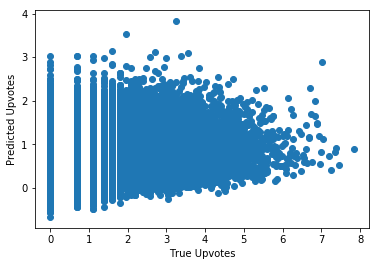

In [43]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Upvotes')
plt.ylabel('Predicted Upvotes')
plt.show()